In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm.auto import tqdm
from pathlib import Path
from icecube_utils import load_pretrained_model, calculate_angular_error, convert_to_3d, inference
from graphnet.training.labels import Direction
from icecube_utils import make_dataloader
from train_large import config, features, truth

/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


graphnet: INFO     2023-03-09 08:37:05 - get_logger - Writing log to logs/graphnet_20230309-083705.log
graphnet: WARNING  2023-03-09 08:37:08 - warn_once - `icecube` not available. Some functionality may be missing.


### Inference split by sigma

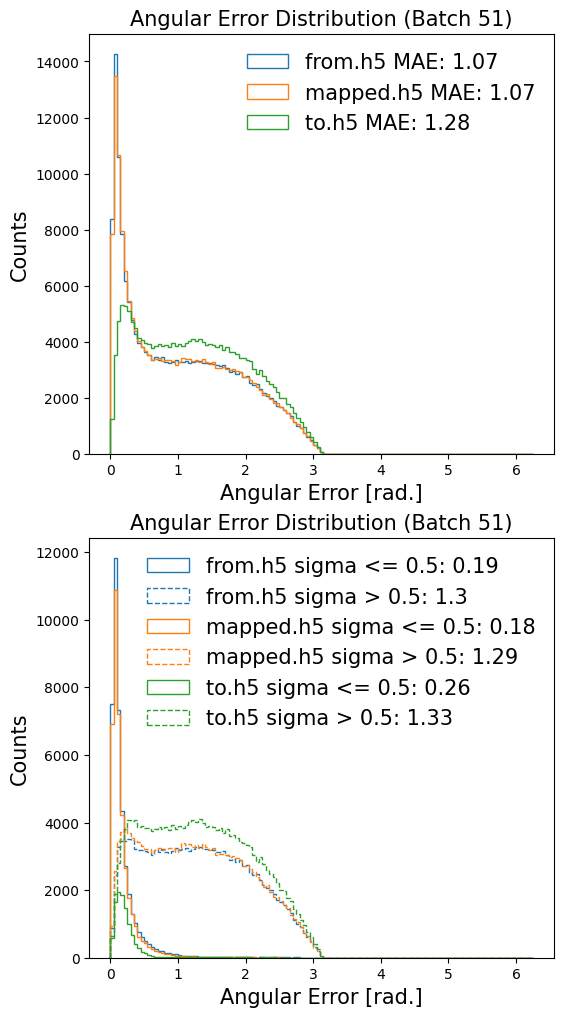

In [3]:
fig, axes = plt.subplots(2, 1, figsize = (6,12))
for result_path in Path('results').glob('*.h5'):
    df = pd.read_hdf(result_path, 'df')

    ax = axes[0]
    ax.hist(df['angular_error'], 
            bins = np.arange(0,np.pi*2, 0.05), 
            histtype = 'step', 
            label = f'{result_path.name} MAE: {np.round(df["angular_error"].mean(),2)}')

    ax = axes[1]
    cut_threshold = 0.5
    _, _, patches = ax.hist(
        df['angular_error'][1/np.sqrt(df['direction_kappa']) <= cut_threshold], 
        bins = np.arange(0,np.pi*2, 0.05), 
        histtype = 'step', 
        label = f'{result_path.name} sigma <= {cut_threshold}: {np.round(df["angular_error"][1/np.sqrt(df["direction_kappa"]) <= cut_threshold].mean(),2)}')
    color = patches[-1].get_edgecolor()

    ax.hist(
        df['angular_error'][1/np.sqrt(df['direction_kappa']) > cut_threshold], 
        bins = np.arange(0,np.pi*2, 0.05), 
        histtype = 'step', 
        color=color,
        linestyle='--',
        label = f'{result_path.name} sigma > {cut_threshold}: {np.round(df["angular_error"][1/np.sqrt(df["direction_kappa"]) > cut_threshold].mean(),2)}')

axes[0].set_xlabel('Angular Error [rad.]', size = 15)
axes[0].set_ylabel('Counts', size = 15)
axes[0].set_title('Angular Error Distribution (Batch 51)', size = 15)
axes[0].legend(frameon = False, fontsize = 15)

axes[1].set_xlabel('Angular Error [rad.]', size = 15)
axes[1].set_ylabel('Counts', size = 15)
axes[1].set_title('Angular Error Distribution (Batch 51)', size = 15)
axes[1].legend(frameon = False, fontsize = 15)

In [4]:
df

,direction_x,direction_y,direction_z,direction_kappa,zenith,azimuth,event_id,true_x,true_y,true_z,angular_error
0,-0.472828,0.024592,-0.880811,3.065326,2.433392,3.306649,2.131984e+09,-0.641628,-0.106877,-0.759534,0.246563
1,-0.770279,-0.199378,-0.605735,0.069154,1.125523,1.581094,2.131984e+09,-0.009294,0.902445,0.430705,2.019349
2,0.106235,0.207508,-0.972448,6.853319,2.725313,1.197849,2.131984e+09,0.147334,0.376564,-0.914600,0.183603
3,-0.139691,-0.443113,0.885515,0.254192,1.249805,1.478068,2.131984e+09,0.087866,0.944846,0.315508,1.722944
4,-0.454675,-0.792394,-0.406671,0.174388,2.138804,1.410056,2.131984e+09,0.134917,0.832108,-0.537954,2.096625
...,...,...,...,...,...,...,...,...,...,...,...
199995,-0.908876,-0.056350,0.413241,0.317032,1.507717,3.996294,2.135242e+09,-0.655139,-0.752874,0.063038,0.844756
199996,0.955554,-0.203548,-0.213270,2.286076,1.904201,6.219577,2.135242e+09,0.943023,-0.060065,-0.327262,0.183940
199997,0.312909,-0.949637,0.016627,0.252292,2.491168,0.358167,2.135242e+09,0.567099,0.212272,-0.795826,1.608168
199998,-0.382566,-0.682727,-0.622515,0.194744,0.225974,0.747326,2.135242e+09,0.164347,0.152286,0.974576,2.455192


### Error vs n_pulses

Cat the n_pulses to existing batch 51 .h5 files

In [13]:
batch_656_dataloader = make_dataloader(
    db = 'data/batch_656.db',
    selection = None,
    pulsemaps = config['pulsemap'],
    features = features,
    truth = truth,
    batch_size = config['batch_size'],
    num_workers = config['num_workers'],
    shuffle = False,
    labels = {'direction': Direction()},
    index_column = config['index_column'],
    truth_table = config['truth_table'],
)

In [14]:
%%capture --no-stdout
dfs = []
for batch in tqdm(batch_656_dataloader):
    df = pd.DataFrame(
        {
            'event_id': batch.event_id, 
            'n_pulses': batch.n_pulses
        }
    )
    dfs.append(df)
df = pd.concat(dfs)

In [15]:
df

,event_id,n_pulses
0,2131983614,83
1,2131983673,29
2,2131983677,110
3,2131983678,84
4,2131983690,49
...,...,...
95,2135241829,57
96,2135241847,40
97,2135241853,71
98,2135241857,66


In [18]:
for result_path in Path('results').glob('*.h5'):
    df_results = pd.read_hdf(result_path, 'df')
    df_results['event_id'] = df_results['event_id'].astype(int)
    df_results = df_results.merge(df, on = 'event_id')
    df_results.to_hdf(
        result_path, 
        'df'
    )

Inference on batch 656 (val) and batch 14 (val)

In [21]:
%%capture --no-stdout
config['path'] = '/workspace/icecube/data/batch_14.db'
config['inference_database_path'] = '/workspace/icecube/data/batch_14.db'
model = load_pretrained_model(
    config=config, 
    state_dict_path='weights/dynedge_multiplier_1_fold_0_max_epochs_10/state_dict.pth',
    return_train_dataloader=False,
)

df = calculate_angular_error(
    convert_to_3d(
        inference(
            model.cuda(), 
            config
        )
    )
)
df.to_hdf(f'results/from_train.h5', key='df', mode='w')
del model
torch.cuda.empty_cache()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2000/2000 [06:06<00:00,  5.46it/s]
graphnet: INFO     2023-03-09 09:09:40 - inference - Writing results to training/train_model_without_configs/batch_14/dynedge_direction_my_example


In [22]:
batch_14_dataloader = make_dataloader(
    db = 'data/batch_14.db',
    selection = None,
    pulsemaps = config['pulsemap'],
    features = features,
    truth = truth,
    batch_size = config['batch_size'],
    num_workers = config['num_workers'],
    shuffle = False,
    labels = {'direction': Direction()},
    index_column = config['index_column'],
    truth_table = config['truth_table'],
)

In [26]:
%%capture --no-stdout
dfs = []
for batch in tqdm(batch_14_dataloader):
    df = pd.DataFrame(
        {
            'event_id': batch.event_id, 
            'n_pulses': batch.n_pulses
        }
    )
    dfs.append(df)
df = pd.concat(dfs)

In [27]:
df

,event_id,n_pulses
0,42316578,1025
1,42316582,58
2,42316606,47
3,42316631,68
4,42316643,45
...,...,...
95,45566080,87
96,45566098,71
97,45566101,81
98,45566103,94


In [29]:
result_path = 'results/from_train.h5'
df_results = pd.read_hdf(result_path, 'df')
df_results['event_id'] = df_results['event_id'].astype(int)
df_results = df_results.merge(df, on = 'event_id')
df_results.to_hdf(
    result_path, 
    'df'
)

Plot

In [46]:
import seaborn as sns

/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


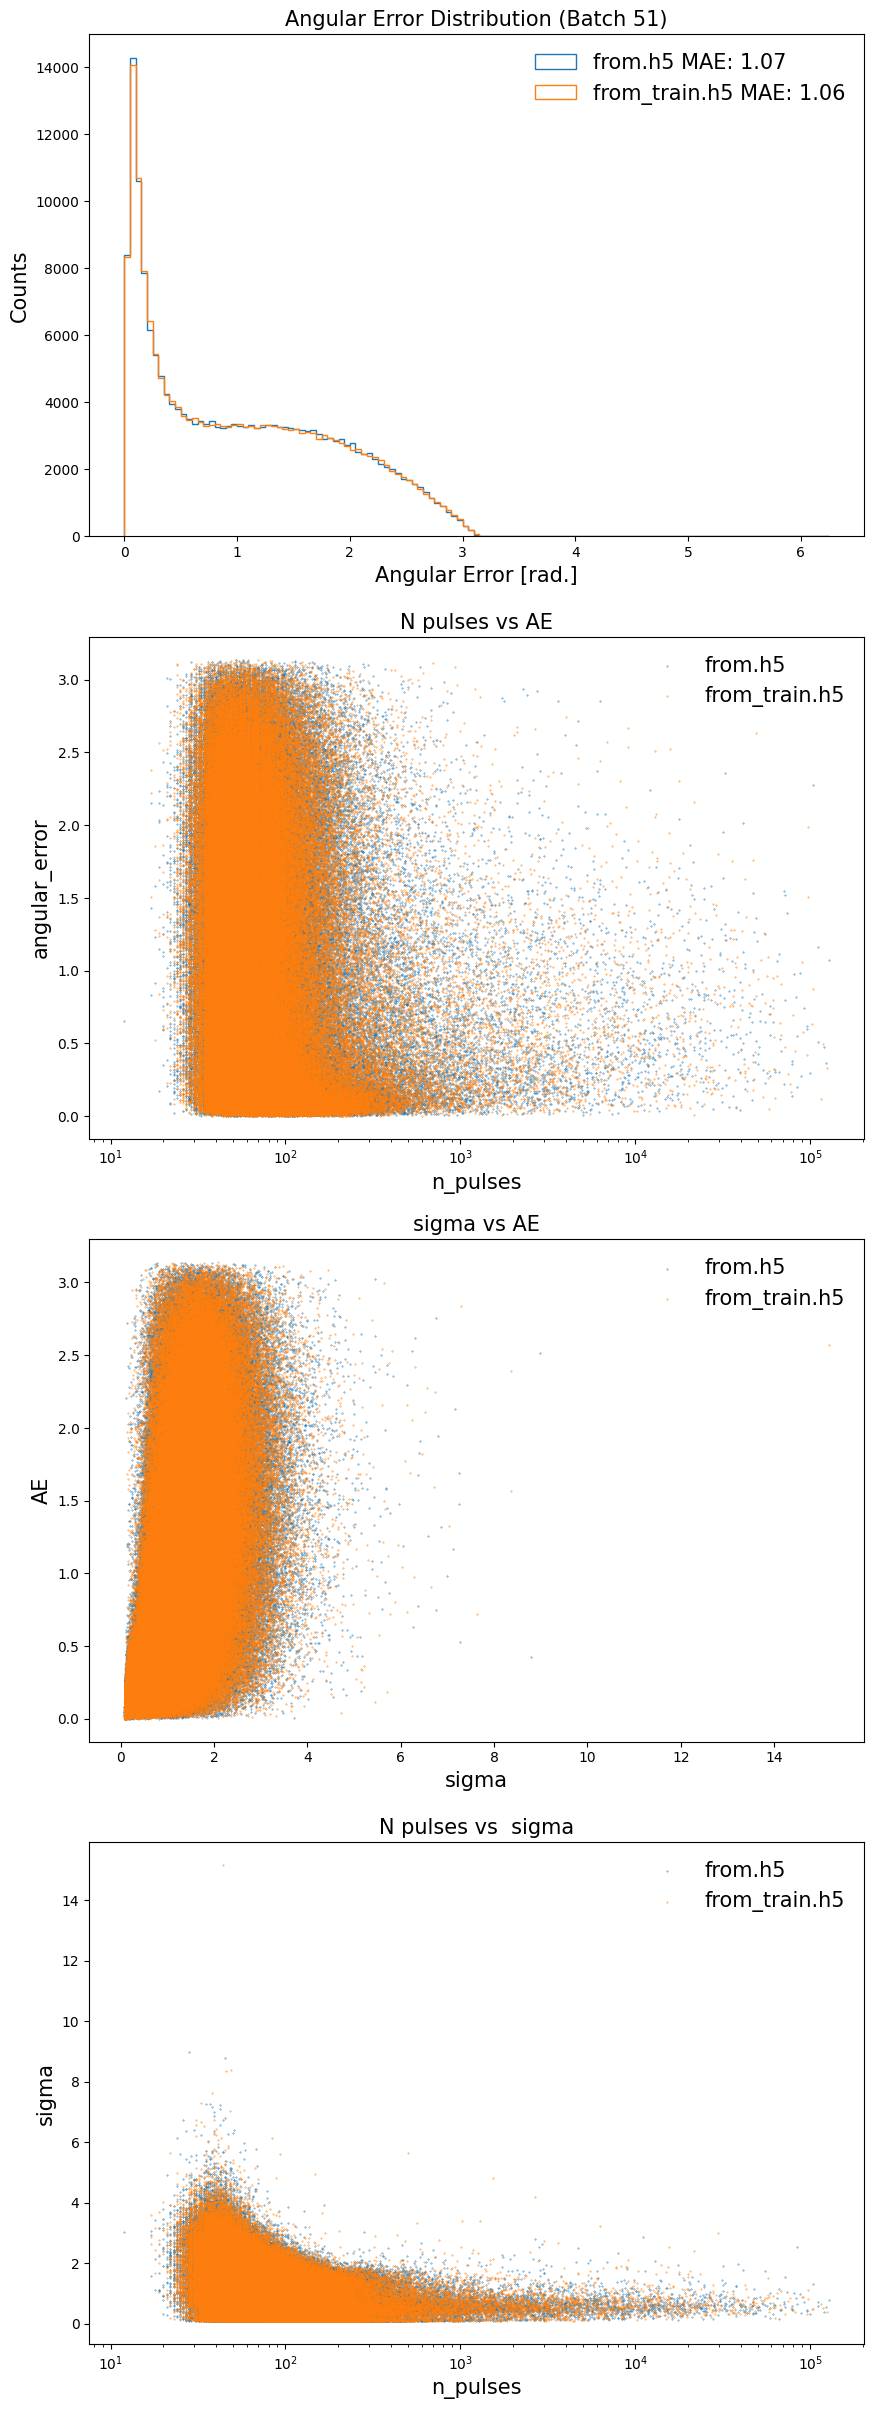

In [55]:
fig, axes = plt.subplots(4, 1, figsize = (10,30))
# for result_path in Path('results').glob('*.h5'):
result_paths = [
    Path('results/from.h5'),
    Path('results/from_train.h5'),
]
for result_path in result_paths:
    df = pd.read_hdf(result_path, 'df')
    df['direction_sigma'] = 1/np.sqrt(df['direction_kappa'])

    ax = axes[0]
    ax.hist(df['angular_error'], 
            bins = np.arange(0,np.pi*2, 0.05), 
            histtype = 'step', 
            label = f'{result_path.name} MAE: {np.round(df["angular_error"].mean(),2)}')

    ax = axes[1]
    mask = df['n_pulses'] < 2000000
    # sns.kdeplot(data=df, x="n_pulses", y="angular_error", ax=ax, log_scalebool=[True, False])
    ax.scatter(df['n_pulses'][mask], df['angular_error'][mask], s=0.1, label = result_path.name)
    ax = axes[2]
    # sns.kdeplot(data=df, x="direction_sigma", y="angular_error", ax=ax, log_scalebool=[False, False])
    ax.scatter(df['direction_sigma'][mask], df['angular_error'][mask], s=0.1, label = result_path.name)
    ax = axes[3]
    # sns.kdeplot(data=df, x="n_pulses", y="direction_sigma", ax=ax, log_scalebool=[True, False])
    ax.scatter(df['n_pulses'][mask], df['direction_sigma'][mask], s=0.1, label = result_path.name)

axes[0].set_xlabel('Angular Error [rad.]', size = 15)
axes[0].set_ylabel('Counts', size = 15)
axes[0].set_title('Angular Error Distribution (Batch 51)', size = 15)
axes[0].legend(frameon = False, fontsize = 15)

axes[1].set_xlabel('n_pulses', size = 15)
axes[1].set_ylabel('angular_error', size = 15)
axes[1].set_title('N pulses vs AE', size = 15)
axes[1].legend(frameon = False, fontsize = 15)
axes[1].set_xscale('log')

axes[2].set_xlabel('sigma', size = 15)
axes[2].set_ylabel('AE', size = 15)
axes[2].set_title('sigma vs AE', size = 15)
axes[2].legend(frameon = False, fontsize = 15)

axes[3].set_xlabel('n_pulses', size = 15)
axes[3].set_ylabel('sigma', size = 15)
axes[3].set_title('N pulses vs  sigma', size = 15)
axes[3].legend(frameon = False, fontsize = 15)
axes[3].set_xscale('log')

In [59]:
import pandas as pd
import sqlite3

my_event_id = 0
my_database = '/workspace/icecube/data/batch_1.db'

with sqlite3.connect(my_database) as conn:
    # extracts meta data for event
    meta_query = f'SELECT * FROM meta_table WHERE event_id ={my_event_id}'
    meta_data = pd.read_sql(meta_query,conn)
    
    # extracts pulses / detector response for event
    pulse_query = f'SELECT * FROM pulse_table WHERE event_id ={my_event_id}'
    pulse_data = pd.read_sql(pulse_query, conn)

In [61]:
meta_data

,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith


In [60]:
pulse_data

,event_id,sensor_id,time,charge,auxiliary,x,y,z
